In [11]:
import matplotlib
# matplotlib.use('Agg')  # Or any other X11 back-end   
import numpy as np
import torch.nn as nn
import torch.nn.init as init

  
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal
import time
import torch
import torch.nn as nn
from torch.autograd import Variable

import h5py
import numpy as np
import os
import pandas as pd
from torch.utils.data import Dataset
import wfdb

%matplotlib inline

In [12]:
# GLOBALS
SIGNALS = ['SaO2',
           'ABD',
           'CHEST',
           'Chin1-Chin2',
           'AIRFLOW',
           'ECG',
           'E1-M2',
           'O2-M1',
           'C4-M1',
           'C3-M2',
           'F3-M2',
           'F4-M1',
           'O1-M2'
          ]

TRAINING_START = 6 
HW = 256
SAMPLES_PER_WINDOW = 50
OVERLAP = SAMPLES_PER_WINDOW#//2 # offset by half the window
MINUTES = 2
raw_window_size = int(MINUTES*60*200)
WS = raw_window_size + (HW - (raw_window_size + HW) % HW)
LR = 1e-3

print('adjusted window size: {}, num bins: {}'.format(WS, WS//HW))


adjusted window size: 24064, num bins: 94


In [13]:
class SleepDataset(Dataset):
    """Physionet 2018 dataset."""

    def __init__(self, records_file, root_dir, s, f, hanning_window, signals):
        """
        Args:
            records_file (string): Path to the records file.
            root_dir (string): Directory with all the signals.

        """
        self.landmarks_frame = pd.read_csv(records_file)[s:f]
        self.root_dir = root_dir
        self.hw = hanning_window
        self.signals = signals

    @staticmethod
    def to_spectogram(matrix, hw):
        spectograms = []
        for i in range(matrix.shape[1]):
            f, t, Sxx = signal.spectrogram(matrix[:,i], 
#                                window=signal.get_window(('exponential', None, 2),hw, False),
                               window=signal.get_window('hann',hw, False), 
                               fs=200, 
                               scaling='density', 
                               mode='magnitude',
                               noverlap=0
                              )
            spectograms.append(Sxx)
        return np.array(spectograms)

        
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        folder_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        file_name = self.landmarks_frame.iloc[idx, 0]
#         print(file_name)
#         print(folder_name)
#         file_name='tr03-0005/'
#         folder_name='../data/training/tr03-0005/'
        signals = wfdb.rdrecord(os.path.join(folder_name, file_name[:-1]))
        arousals = h5py.File(os.path.join(folder_name, file_name[:-1] + '-arousal.mat'), 'r')
        tst_ann = wfdb.rdann(os.path.join(folder_name, file_name[:-1]), 'arousal')
                
        arous_data = arousals['data']['arousals'].value.ravel()
                
        signal_idxs = np.nonzero(np.in1d(signals.sig_name, self.signals))[0]
        spectrograms = self.to_spectogram(signals.p_signal[:, signal_idxs], self.hw)
#         print(len(arous_data))
        
        chunk_labels = np.split(arous_data[:(len(arous_data)//self.hw)*self.hw].clip(min=0), len(arous_data)//self.hw)
        chunk_labels = np.mean(chunk_labels, axis=1)
        
#         f, a = plt.subplots(14, 1, figsize=(10,10))
#         a[0].plot(chunk_labels)
#         a[0].set_xlim([0, len(chunk_labels)])
#         for i in range(13):
#             a[i+1].imshow(spectrograms[i], aspect='auto')
        
#         plt.show()
        
    
        return spectrograms, chunk_labels
        
# TRAINING_START = 6      
# d = SleepDataset('/beegfs/ga4493/projects/groupb/data/training/RECORDS', 
#                              '/beegfs/ga4493/projects/groupb/data/training/', TRAINING_START, TRAINING_START+1, 512, SIGNALS)
# d[0]        
        

In [14]:


#TODO add torch.save(the_model.state_dict(), PATH) this to save the best models weights

train_dataset = SleepDataset('/beegfs/ga4493/projects/groupb/data/training/RECORDS', 
                             '/beegfs/ga4493/projects/groupb/data/training/', TRAINING_START, TRAINING_START+1, HW, SIGNALS)

train_loaders = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True)

# test_dataset = SleepDataset('/beegfs/ga4493/projects/groupb/data/training/RECORDS', 
#                                 '/beegfs/ga4493/projects/groupb/data/training/', 0, 1, window_size, hanning_window, signals, validation=False)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
#                                           batch_size=1, 
#                                           shuffle=False)

In [15]:
class LSTM_1(nn.Module):

    def __init__(self, window_size, han_size, num_signals):
        super(LSTM_1, self).__init__()
        num_bins = window_size
        self.num_directions = 2
        self.hidden_size = num_bins*2
        self.num_features = 32
                
        self.pad = nn.ZeroPad2d((3, 3, 0, 0))
        
        self.cnns = []
        self.cnns2 = [] 
        for i in range(num_signals):
            self.cnns.append(nn.Conv2d(1, 16, (han_size//2+1, 7)))
        
            init.xavier_uniform(self.cnns[-1].weight, gain=nn.init.calculate_gain('relu'))
            init.constant(self.cnns[-1].bias, 0.1)
            
            self.cnns2.append(nn.Conv2d(16, self.num_features, (1, 7)))
        
            init.xavier_uniform(self.cnns2[-1].weight, gain=nn.init.calculate_gain('relu'))
            init.constant(self.cnns2[-1].bias, 0.1)
        
        self.cnns = nn.ModuleList(self.cnns)
        self.cnns2 = nn.ModuleList(self.cnns2)
#         self.cnn2 = nn.Conv2d(num_signals, self.num_features, (self.num_features, 5))
        
#         init.xavier_uniform(self.cnn2.weight, gain=nn.init.calculate_gain('relu'))
#         init.constant(self.cnn2.bias, 0.1)
        
        self.gru = nn.GRU(self.num_features, self.hidden_size, num_layers=4, bidirectional=True)
        self.lstm = nn.LSTM(self.num_features, self.hidden_size, num_layers=2, bidirectional=True)

        self.ap = nn.AdaptiveMaxPool2d((num_bins, self.num_features))
        
        self.reshape1 = nn.Conv2d(13, 6, 1)
        init.xavier_uniform(self.reshape1.weight, gain=nn.init.calculate_gain('relu'))
        init.constant(self.reshape1.bias, 0.1)
        self.reshape2 = nn.Conv2d(6, 1, 1)
        init.xavier_uniform(self.reshape2.weight, gain=nn.init.calculate_gain('relu'))
        init.constant(self.reshape2.bias, 0.1)
        
        self.fc = nn.Linear(self.num_features*num_bins, num_bins)#self.hidden_size*self.num_directions)
        
        self.out = nn.Linear(num_bins, num_bins)
        
        self.sig = nn.Sigmoid()
        self.relu = nn.ReLU()
#         self.tanh = nn.Tanh()
   
    def init_hidden(self, batch_size):
        # variable of size [num_layers*num_directions, b_sz, hidden_sz]
        return Variable(torch.zeros(4*self.num_directions, batch_size, self.hidden_size)).cuda() 

    def forward(self, x):
#         f, ax = plt.subplots(13, 1, figsize=(10,10))
        
        x = self.pad(x)
        t = []
        tmp = x.cpu().squeeze(0).data.numpy()
        for i in range(x.size()[1]):
#             ax[i].imshow(tmp[i], aspect='auto')
            a = x[:,0,:,:].unsqueeze(0)
            t.append(self.relu(self.cnns2[i](self.pad(self.relu(self.cnns[i](a))))))
#         plt.show()
        x = torch.stack(t).transpose(2, 3).transpose(0,2).squeeze(0)
#         print(x.size())
#         x = self.ap(x)
        x = self.relu(self.reshape1(x))
        x = self.relu(self.reshape2(x))
#         print(x.size())
#         x = x.transpose(1,3).squeeze(0)
#         print(x.size())
#         x = x.transpose(1,2)
#         print(x.size())
#         x = self.pad(x)
#         x = self.relu(self.cnn2(x))
#         x = x.transpose(1,3).squeeze(0)
#         h = self.init_hidden(1)
#         x, h = self.gru(x)
#         print(x.size())
#         print(x.view(-1))
        x = self.fc(x.view(-1))
        x = self.out(x)
        return self.sig(x)


# LSTM_1(SAMPLES_PER_WINDOW, HW, len(SIGNALS))(spectrograms[:,:,:,start_pos:end_pos].type(torch.FloatTensor))

In [20]:


model = LSTM_1(SAMPLES_PER_WINDOW, HW, len(SIGNALS))

if torch.cuda.is_available():
    print('using cuda')
    model.cuda()

criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)

losses = []
v_losses = []
accuracy = []
v_accuracy = []
l = None
for epoch in range(200):
    loss_t = 0.0
    acc_t = 0.0
    count_t = 0
    start_time = time.time()
    val_l = None
    v_out = None
    v_all = []
    for c, (spectrograms, labels) in enumerate(train_loaders):
        for i in range(61, 65):# range(labels.size()[1]//OVERLAP-1):
            start_pos = (i*OVERLAP)
            end_pos = (i+1)*OVERLAP#+OVERLAP
            optimizer.zero_grad()
            inp_subs = spectrograms[:,:,:,start_pos:end_pos].type(torch.FloatTensor)
            l = labels[:,start_pos:end_pos].type(torch.FloatTensor)
            if torch.cuda.is_available():
                l = l.cuda()
                inp_subs = inp_subs.cuda()
            l = Variable(l)
#             print(l)
            inp_subs = Variable(inp_subs)

            output = model(inp_subs)

            loss = criterion(output, l.view(-1))
#             print(loss)
            
            loss_t += loss.data[0]
            
            comparison = (output.cpu().data.numpy().ravel() > 0.5) == (l.cpu().data.numpy())
            acc_t += comparison.sum() / SAMPLES_PER_WINDOW
            
            count_t += 1
            
            loss.backward()
            optimizer.step()
    losses.append(loss_t/count_t)
    accuracy.append(acc_t/count_t)
    #####
#     loss_v = 0.0
#     acc_v = 0.0
#     count_v = 0
#     for c, ((data, windexes), v_l) in enumerate(test_loader):
#         for i, win in enumerate(windexes.numpy()[0]):
#             inp_subsv = Variable(to_spectogram2(data[:,win*window_size:(win+1)*window_size,]))
#             lv = None
#             lv = v_l[0, i].type(torch.FloatTensor)
#             if torch.cuda.is_available():
#                 lv = lv.cuda()
#             lv = Variable(lv)
#             outputv = model_v1(inp_subsv)
#             lossv = criterion(outputv, lv)

#             loss_v += lossv.data[0]
#             count_v += 1
            
#             comparison = (output.cpu().data.numpy().ravel() > 0.5) == (lv.cpu().data.numpy())
#             acc_v += comparison.sum() / (window_size//hanning_window)
            
#     v_losses.append(loss_v/count_v)
#     v_accuracy.append(acc_v/count_v)
    print('#'*45)
    print('# epoch  - {:>10} | time(s) -{:>10.2f} #'.format(epoch, time.time() - start_time))
    print('# T loss - {:>10.6f} | V loss - {:>10.6f} #'.format(loss_t/count_t, 0))#loss_v/count_v))
    print('# T acc  - {:>10.6f} | V acc  - {:>10.6f} #'.format(acc_t/count_t, 0))#acc_v/count_v))
print('#'*45)


using cuda
#############################################
# epoch  -          0 | time(s) -      5.78 #
# T loss -   0.714357 | V loss -   0.000000 #
# T acc  -   0.460000 | V acc  -   0.000000 #
#############################################
# epoch  -          1 | time(s) -      5.75 #
# T loss -   0.704334 | V loss -   0.000000 #
# T acc  -   0.465000 | V acc  -   0.000000 #
#############################################
# epoch  -          2 | time(s) -      5.79 #
# T loss -   0.690111 | V loss -   0.000000 #
# T acc  -   0.505000 | V acc  -   0.000000 #
#############################################
# epoch  -          3 | time(s) -      5.76 #
# T loss -   0.676121 | V loss -   0.000000 #
# T acc  -   0.535000 | V acc  -   0.000000 #
#############################################
# epoch  -          4 | time(s) -      5.73 #
# T loss -   0.662941 | V loss -   0.000000 #
# T acc  -   0.585000 | V acc  -   0.000000 #
#############################################
# epoch  -          5 |

#############################################
# epoch  -         45 | time(s) -      5.89 #
# T loss -   0.107235 | V loss -   0.000000 #
# T acc  -   0.970000 | V acc  -   0.000000 #
#############################################
# epoch  -         46 | time(s) -      5.85 #
# T loss -   0.098950 | V loss -   0.000000 #
# T acc  -   0.970000 | V acc  -   0.000000 #
#############################################
# epoch  -         47 | time(s) -      5.84 #
# T loss -   0.091436 | V loss -   0.000000 #
# T acc  -   0.970000 | V acc  -   0.000000 #
#############################################
# epoch  -         48 | time(s) -      5.82 #
# T loss -   0.084648 | V loss -   0.000000 #
# T acc  -   0.970000 | V acc  -   0.000000 #


KeyboardInterrupt: 

0.08026222698390484


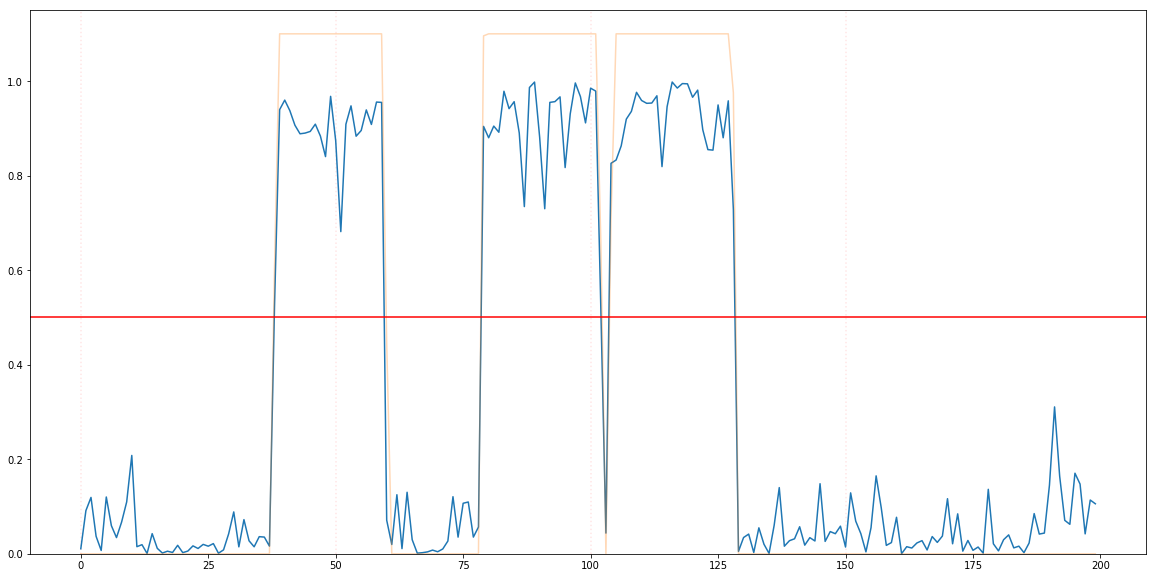

In [21]:
w_start = 61
w_end = 65
for c, (spectrograms, labels) in enumerate(train_loaders):
    out_for_plot = []
    f = plt.figure(figsize=(20, 10))
    out_labels = []
    los_t = 0.0
    acc_t = 0.0
    cou_t = 0
#     for i in range((data.size()[1]//window_size)):
    for i in range(w_start, w_end):
        
        start_pos = (i*SAMPLES_PER_WINDOW)
        end_pos = (i+1)*SAMPLES_PER_WINDOW
        plt.axvline(x=((i-w_start)*SAMPLES_PER_WINDOW), color='r', linestyle=':', alpha=0.1)
        inp_s = Variable(spectrograms[:,:,:,start_pos:end_pos].type(torch.FloatTensor).cuda())
        tl = Variable(labels[:,start_pos:end_pos].type(torch.FloatTensor).cuda())
        outt = model(inp_s)
        los = criterion(outt, tl.view(-1))
        los_t += los.data[0]
        outt = outt.cpu().data.numpy()
        out_for_plot = np.append(out_for_plot, outt)
        cou_t += 1
#     out_for_plot = np.repeat(out_for_plot, W)
    print(los_t/cou_t)
    plt.plot(out_for_plot)
    plt.plot(labels.numpy()[0][w_start*SAMPLES_PER_WINDOW:w_end*SAMPLES_PER_WINDOW].astype(float)*1.1, alpha=0.3)
    plt.ylim((0,1.15))
    plt.axhline(y=0.5, color='r', linestyle='-')
    plt.show()

Variable containing:

Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 19 
    0     0     0     0     0     0     0
[torch.cuda.FloatTensor of size 1x20 (GPU 0)]

IndexError: trying to index 3 dimensions of a 1 dimensional tensor

In [207]:
labs = v_l.numpy()[0]
for i in range(2250000//window_size, stop//window_size):
    print(i - 2250000//window_size)
    plt.imshow(to_spectogram(data[:,i*window_size:(i+1)*window_size,]).cpu().squeeze(0)[6].numpy(), aspect='auto')
    plt.show()
    tmp = []
    for j in range(47): #num bins per window
        bin_s = j*hanning_window + i*window_size
        bin_e = (j+1)*hanning_window + i*window_size
        if labs[bin_s:bin_e].max() > 0:
            tmp.append(1)
        else:
            tmp.append(0)
    print(tmp)

In [29]:
for i in range(len(output)):
    print(output[i])
    print(l[i])
print(windexes)

0.0484689
Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.0327453
Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.0336527
Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.0365041
Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.0590722
Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.0495782
Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.247749
Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.67554
Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.622088
Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.928373
Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.953588
Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.925378
Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU 0)]

0.943239
Variable containing:
 1
[torch.cuda.FloatTensor of size 1 (GPU

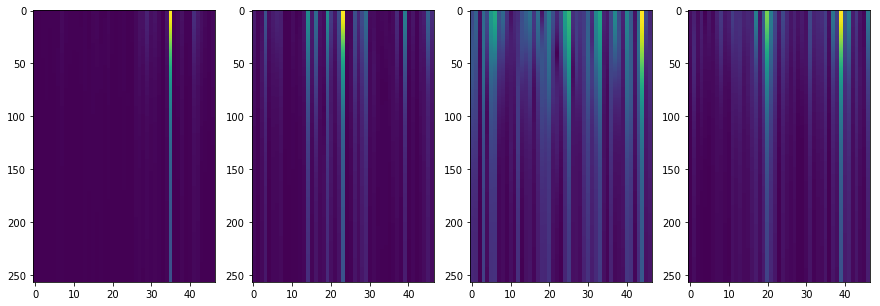

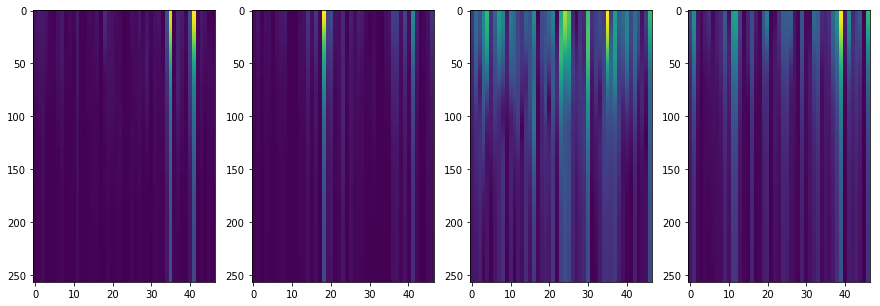

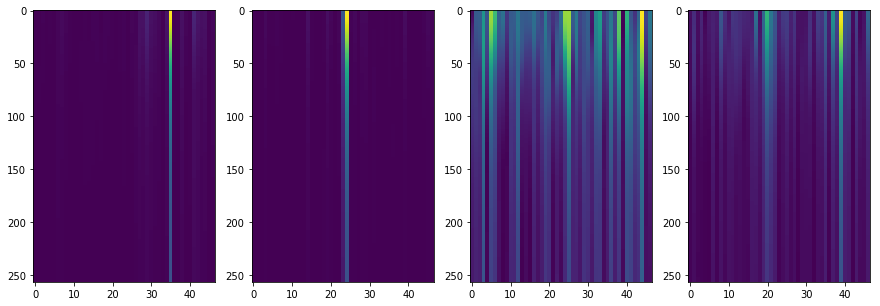

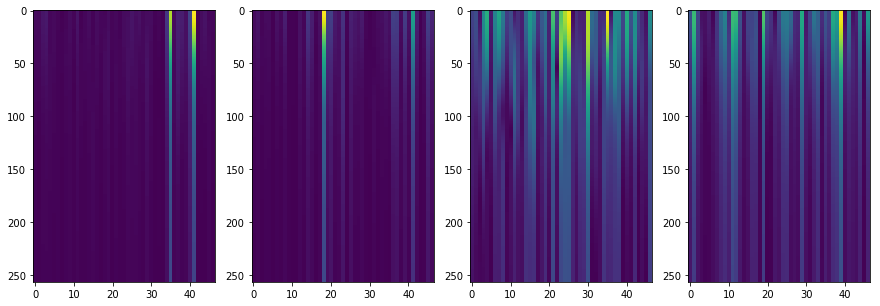

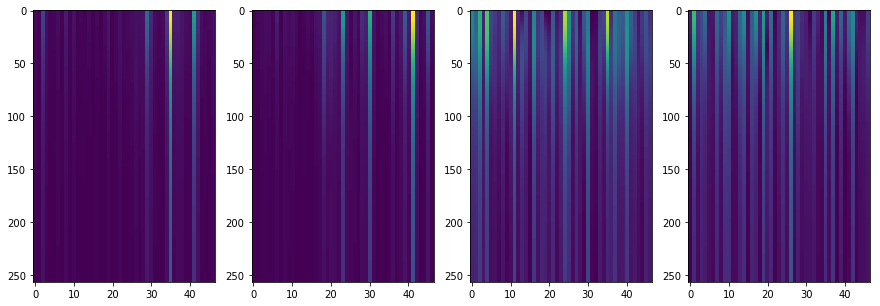

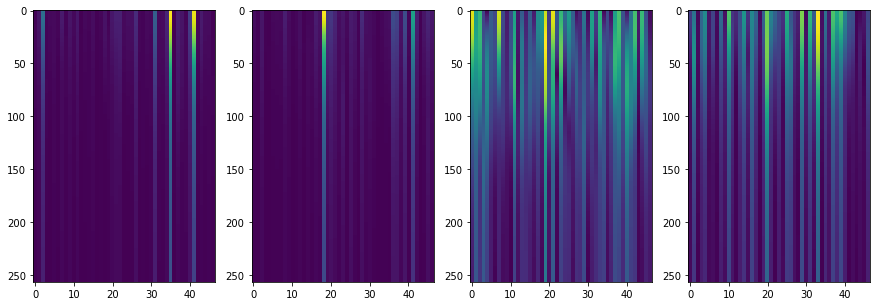

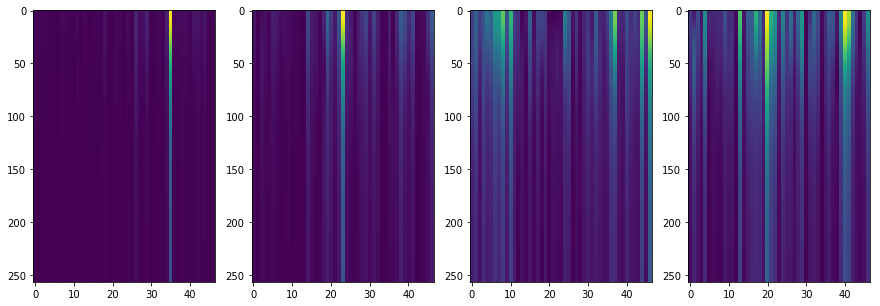

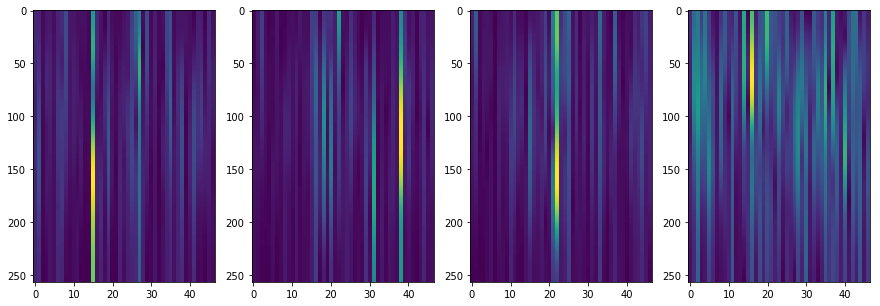

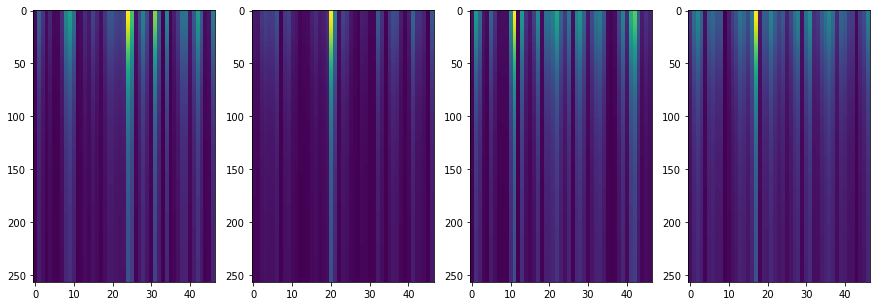

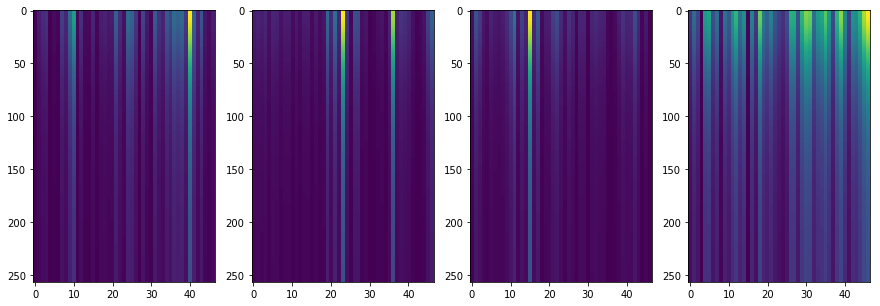

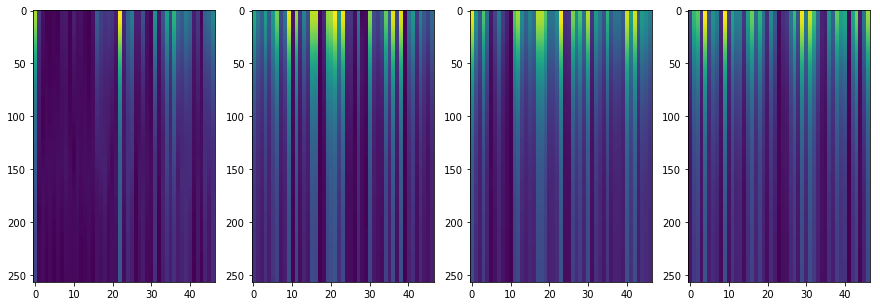

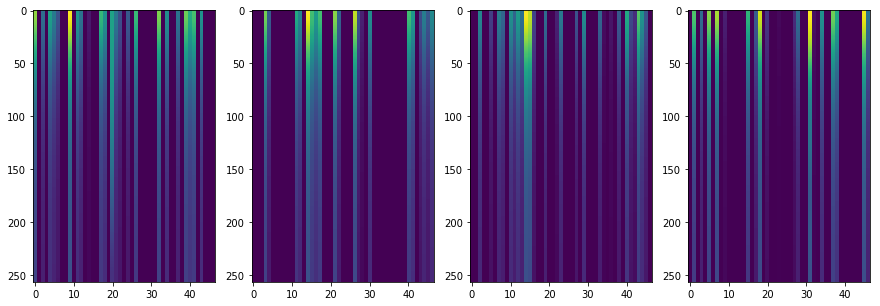

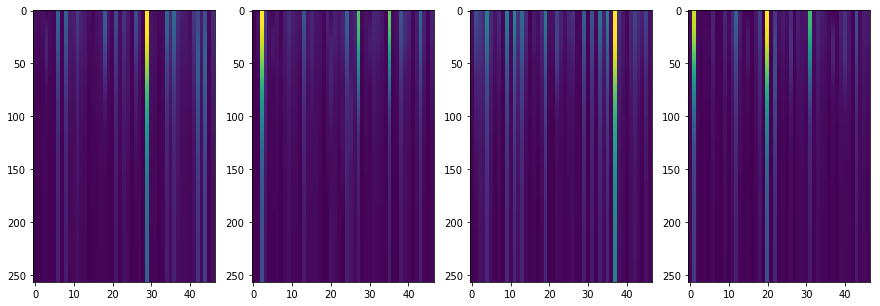

In [31]:

for i in range(13):
    fig, ax = plt.subplots(1,4, figsize=(15, 5))
    ax[0].imshow(to_spectogram2(data[:,3*window_size:(3+1)*window_size,]).cpu().squeeze(0)[i].numpy(), aspect='auto')
    ax[1].imshow(to_spectogram2(data[:,45*window_size:(45+1)*window_size,]).cpu().squeeze(0)[i].numpy(), aspect='auto')
    ax[2].imshow(to_spectogram2(data[:,15*window_size:(15+1)*window_size,]).cpu().squeeze(0)[i].numpy(), aspect='auto')
    ax[3].imshow(to_spectogram2(data[:,31*window_size:(31+1)*window_size,]).cpu().squeeze(0)[i].numpy(), aspect='auto')

    plt.show()


In [107]:
 kernels = [[k[0].cpu().data.numpy() for k in model_v1.cnns[i].weight] for i in range(6)]

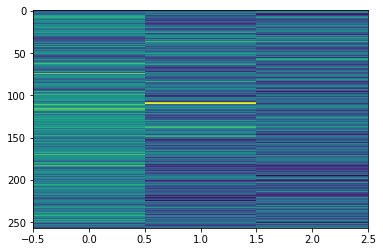

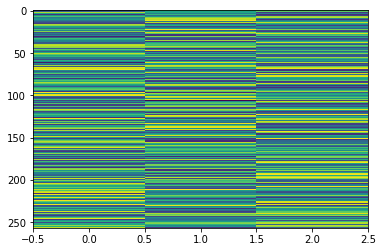

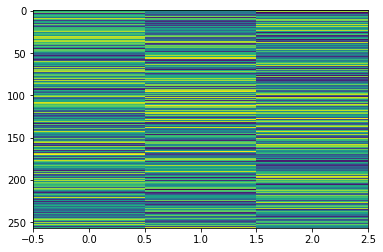

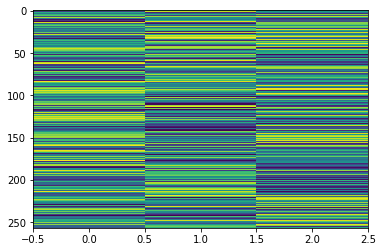

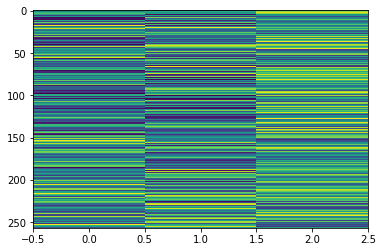

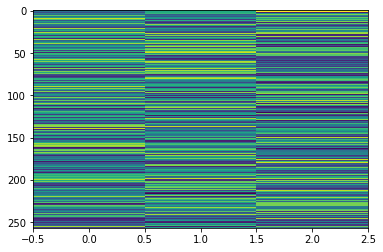

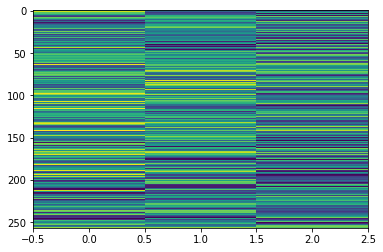

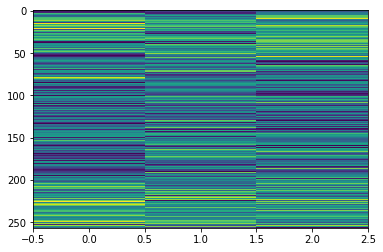

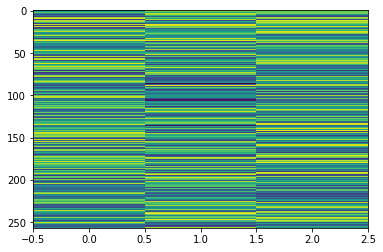

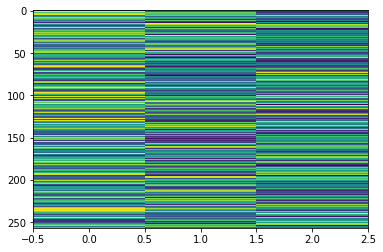

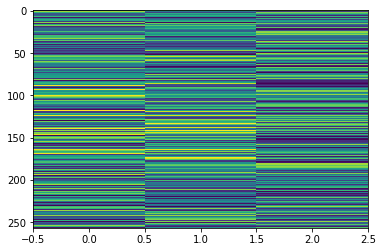

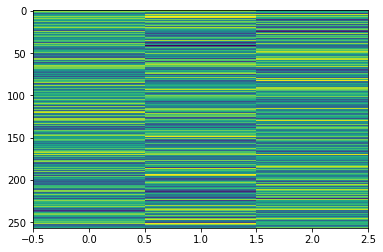

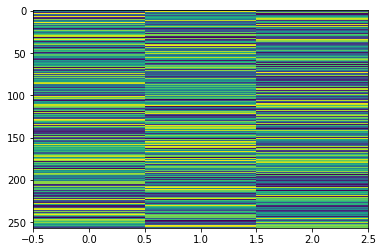

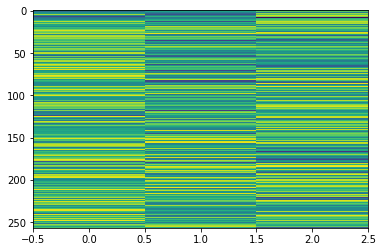

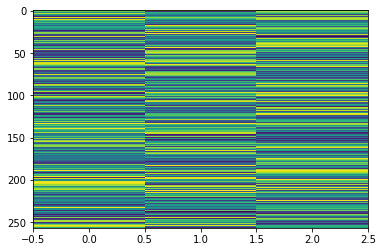

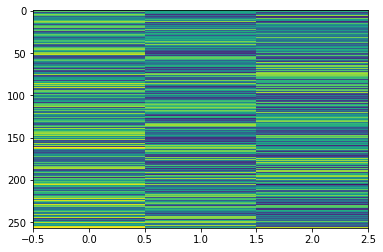

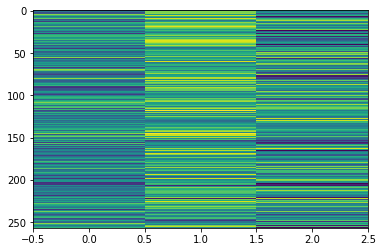

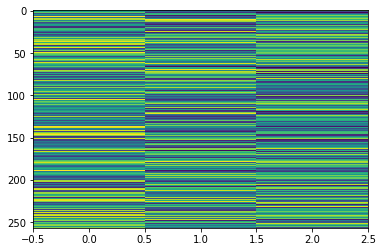

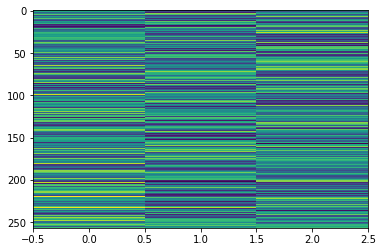

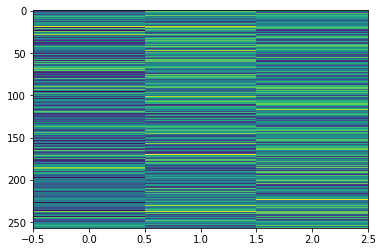

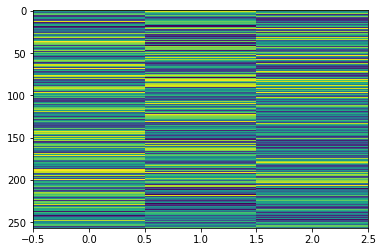

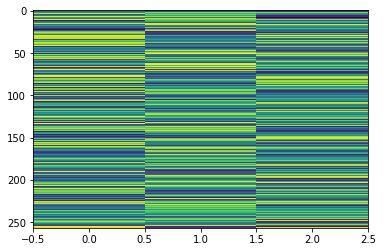

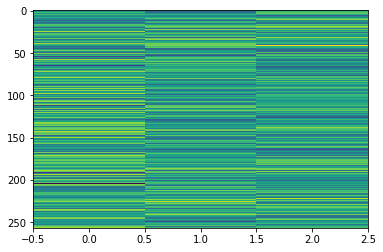

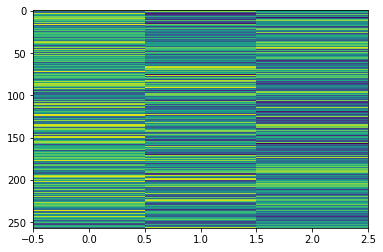

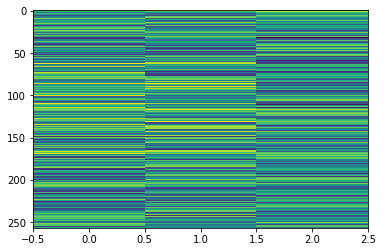

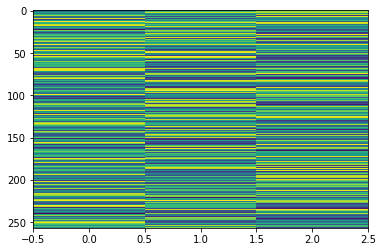

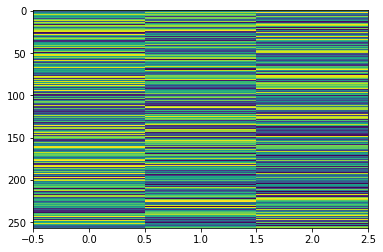

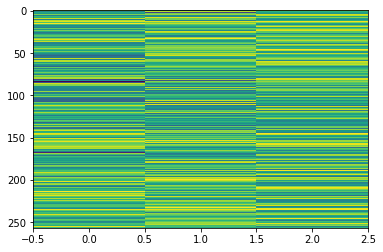

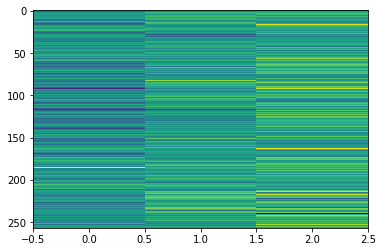

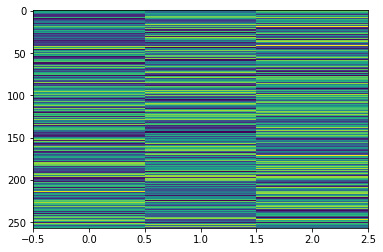

In [108]:
for c in kernels:
    for k in c:
        plt.imshow(k, aspect='auto')
        plt.show()

In [10]:
def to_spectogram2(matrix):
    spectograms = []
    for i in range(all_data.size()[2]):
        f, t, Sxx = signal.spectrogram(matrix[0,:,i].numpy(), 
                           window=signal.get_window(('exponential', 0, 2),hanning_window, True), 
                           fs=200, 
                           scaling='density', 
                           mode='magnitude',
                           noverlap=0
                          )
        if (Sxx.min() != 0 or Sxx.max() != 0):
#             spectograms.append((Sxx - Sxx.mean()) / Sxx.std())
            spectograms.append((Sxx - Sxx.min()) / (Sxx.max() - Sxx.min()))
        else:
            spectograms.append(Sxx)
    return torch.FloatTensor(spectograms).unsqueeze(0).cuda()
# to_spectogram2(data[:,i*window_size:(i+1)*window_size,]).cpu().squeeze(0)[0].numpy().max()
# for i in range(13):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].imshow(to_spectogram(data[:,i*window_size:(i+1)*window_size,]).cpu().squeeze(0)[i].numpy(), aspect='auto')
#     ax[1].imshow(to_spectogram2(data[:,i*window_size:(i+1)*window_size,]).cpu().squeeze(0)[i].numpy(), aspect='auto')
#     plt.show()

In [44]:
for c, ((all_data, windexes), labels) in enumerate(train_loaders):
#     print(windexes)
    for i, win in enumerate(windexes.numpy()[0]):

        a = model_v1(to_spectogram2(all_data[:,win*window_size:(win+1)*window_size,])).cpu().data.numpy()
        b = model_v1(to_spectogram2(all_data[:,(win+2)*window_size:(win+2+1)*window_size,])).cpu().data.numpy()
#         l = 
        for j in range(len(a)):
            print('{:.4f} {:.4f} {}'.format(a[j], b[j], labels[0, i].numpy()[j]))
        

0.0423 0.0381 0
0.0339 0.0310 0
0.0321 0.0290 0
0.0322 0.0292 0
0.0482 0.0443 0
0.0267 0.0247 0
0.0429 0.0406 0
0.1225 0.1193 0
0.2772 0.2750 0
0.2361 0.2375 0
0.2366 0.2453 0
0.2564 0.2662 0
0.1712 0.1730 0
0.1890 0.1894 0
0.1950 0.1974 0
0.1976 0.2043 0
0.1258 0.1304 0
0.1250 0.1270 0
0.1251 0.1282 0
0.1613 0.1612 0
0.1322 0.1325 0
0.0434 0.0423 0
0.0237 0.0217 0
0.0218 0.0211 0
0.0200 0.0189 0
0.0278 0.0260 0
0.0290 0.0271 0
0.0288 0.0265 0
0.0258 0.0249 0
0.1512 0.1512 0
0.1881 0.1786 0
0.1939 0.1840 0
0.1638 0.1542 0
0.1597 0.1496 0
0.1894 0.1792 0
0.1742 0.1643 0
0.1064 0.1008 0
0.1598 0.1530 0
0.1996 0.1957 0
0.2110 0.2025 0
0.1799 0.1787 0
0.1722 0.1715 0
0.1795 0.1758 0
0.1685 0.1618 0
0.1804 0.1819 0
0.0516 0.0479 0
0.0541 0.0512 0
0.0360 0.0212 0
0.0295 0.0192 0
0.0274 0.0157 0
0.0273 0.0188 0
0.0418 0.0411 0
0.0233 0.0286 0
0.0384 0.0629 0
0.1169 0.7227 0
0.2715 0.7375 1
0.2383 0.8409 1
0.2483 0.8536 1
0.2677 0.8783 1
0.1746 0.8783 1
0.1889 0.7580 1
0.1970 0.8379 1
0.2062 0

0.0391 0.0142 0
0.0255 0.0133 0
0.0265 0.0100 0
0.0272 0.0120 0
0.0501 0.0282 0
0.0394 0.0229 0
0.2243 0.0755 0
0.6643 0.7540 0
0.6222 0.7758 0
0.9341 0.8814 1
0.9587 0.8968 1
0.9334 0.9178 1
0.9471 0.9113 1
0.9645 0.8313 1
0.9538 0.8895 1
0.9575 0.8876 1
0.9319 0.5170 1
0.9382 0.4686 1
0.9364 0.5327 1
0.8188 0.2279 1
0.9253 0.5666 1
0.9328 0.5291 1
0.7479 0.0938 1
0.2898 0.0770 0
0.2159 0.0822 0
0.3137 0.0667 0
0.2928 0.0714 0
0.1984 0.0605 0
0.2812 0.0730 0
0.3143 0.1772 0
0.3817 0.1061 0
0.3277 0.1163 0
0.7534 0.1923 1
0.6872 0.1875 1
0.7838 0.1675 1
0.5185 0.0753 1
0.6479 0.0631 1
0.5209 0.0769 1
0.7518 0.3721 1
0.7732 0.3787 1
0.7067 0.2946 1
0.7475 0.3632 1
0.7613 0.3320 1
0.6718 0.4716 1
0.7374 0.3704 1
0.8447 0.2306 1
0.3753 0.1853 0
0.1254 0.0131 0
0.1731 0.0135 0
0.1217 0.0099 0
0.1208 0.0120 0
0.3379 0.0280 1
0.3334 0.0228 1
0.6920 0.0746 1
0.8380 0.7622 1
0.8159 0.7797 1
0.8935 0.8886 1
0.9093 0.9004 1
0.9267 0.9268 1
0.8953 0.9201 1
0.8930 0.8361 1
0.8929 0.8948 1
0.8886 0